## Imports

In [ ]:
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from collections import Counter
from PIL import Image
from tqdm import tqdm
from pathlib import Path

import os
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models.detection as detection
import sys, subprocess

from ultralytics import RTDETR
from ultralytics import YOLO

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

from config import root

## RTDETR

### Model

In [ ]:
model = RTDETR('rtdetr-l.pt')

results = model.train(
    data=root+'/data.yaml',
    epochs=5,
    imgsz=640,
    batch=8,
    name='math_rtdetr'
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/dlcv/YOLO_dataset/data_marie2.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=math_rtdetr2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

### Predictions and eval

In [ ]:
metrics = model.val()

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,991,960 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 1.2±0.6 MB/s, size: 1.9 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1-YQ85lGPGEkbtO30PCUgFmtxt3yu8kDe/YOLO_dataset/labels/val.cache... 1999 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1999/1999 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 125/125 1.4it/s 1:31
                   all       1999      19394      0.873      0.872      0.862      0.715
                letter       1183       5242      0.909      0.827      0.834       0.72
                 digit       1087       4518      0.875      0.911      0.899       0.74
              operator       1154       2721      0.878      0.873      0.868      0.658
                 other       1670       6913      0.831      0.875      0

In [ ]:
predictions = model.predict(root+'/images/train/001-equation001.png', conf=0.5)


image 1/1 /content/drive/MyDrive/dlcv/YOLO_dataset/images/train/001-equation001.png: 640x640 6 letters, 3 digits, 3 operators, 6 others, 58.6ms
Speed: 2.8ms preprocess, 58.6ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
results = model.predict(root+'/images/train/001-equation002.png', save=True, conf=0.5)
result = results[0]
boxes = result.boxes

print("Boxes (xyxy):", boxes.xyxy)
print("Boxes (xywhn):", boxes.xywhn) # normalized coord (format xywhn : x_center, y_center, width, height normalized)
print("Confidence:", boxes.conf)
print("Classes:", boxes.cls)

for i, box in enumerate(boxes):
    xyxy = box.xyxy[0].tolist()  # [xmin, ymin, xmax, ymax]
    conf = box.conf[0].item()     # confidence score
    cls_id = int(box.cls[0].item())  # class id
    cls_name = result.names[cls_id]  # class name

    print(f"Box {i}: {cls_name} (conf: {conf:.2f}) -> [{xyxy[0]:.1f}, {xyxy[1]:.1f}, {xyxy[2]:.1f}, {xyxy[3]:.1f}]")


image 1/1 /content/drive/MyDrive/dlcv/YOLO_dataset/images/train/001-equation002.png: 640x640 7 letters, 3 digits, 3 others, 65.9ms
Speed: 2.5ms preprocess, 65.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict
Boxes (xyxy): tensor([[146.6695,  14.6585, 167.7846,  44.6087],
        [435.1287,  20.7451, 458.4171,  36.8410],
        [474.2053,  26.4884, 488.5154,  59.4879],
        [ 37.3477,  30.6779,  64.6942,  43.9019],
        [368.8954,  26.7201, 394.3566,  40.4666],
        [268.0767,  19.9042, 292.5310,  38.7428],
        [ 94.7336,  16.7847, 115.9165,  40.7345],
        [227.3958,  30.0844, 239.5676,  57.6083],
        [203.9463,   9.8438, 221.7298,  43.9848],
        [173.8165,  36.0718, 179.6688,  49.0253],
        [319.3467,  14.4894, 340.1412,  37.8833],
        [354.1084,  34.0495, 358.5114,  45.3752],
        [  8.9852,  10.8072,  33.0398,  36.7475]], device='cuda:0')
Boxes (xywhn): tensor([[0.3145, 0.4233, 0.0

In [ ]:
def evaluate_yolo_model_simple(model, data_yaml_path, imgsz=640, conf=0.25):
    metrics = model.val(
        data=data_yaml_path,
        imgsz=imgsz,
        conf=conf,
        split='val',
        plots=False
    )

    results = {
        'mAP50': metrics.box.map50,       # mAP à IoU=0.5
        'mAP50-95': metrics.box.map,      # mAP moyenne sur 0.5:0.95
        'precision': metrics.box.p,       # Précision globale
        'recall': metrics.box.r,          # Rappel global
        'fitness': metrics.box.fitness    # Score de fitness
    }

    print('=== SIMPLIFIED EVALUATION RESULTS ===')
    print("mAP@0.5: ",results['mAP50'])
    print("mAP@0.5:0.95: ",results['mAP50-95'])
    print("Precision (P):",results['precision'])
    print("Recall (R):",results['recall'])
    return results

data_config = root+'/data.yaml'
metrics = evaluate_yolo_model_simple(model, data_config, conf=0.25)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,991,960 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 1.3±0.9 MB/s, size: 2.1 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1-YQ85lGPGEkbtO30PCUgFmtxt3yu8kDe/YOLO_dataset/labels/val.cache... 1999 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1999/1999 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 125/125 1.4it/s 1:28
                   all       1999      19394      0.885      0.832      0.872      0.756
                letter       1183       5242      0.915       0.81      0.872      0.777
                 digit       1087       4518      0.887      0.885      0.903      0.775
              operator       1154       2721      0.896      0.804      0.858      0.696
                 other       1670       6913      0.841      0.829      0

### bboxes print on 1 prediction

In [ ]:
def plot_image_with_boxes(img_tensor, gt_boxes=None, pred_boxes=None, pred_scores=None, score_thresh=0.0, figsize=(6,6)):
    img = img_tensor.cpu().permute(1,2,0).numpy()
    fig,ax = plt.subplots(1,figsize=figsize)
    ax.imshow(img)
    if gt_boxes is not None:
        for b in gt_boxes:
            x1,y1,x2,y2 = b
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    if pred_boxes is not None:
        for i,b in enumerate(pred_boxes):
            s = pred_scores[i] if (pred_scores is not None and i<len(pred_scores)) else 1.0
            if s < score_thresh: continue
            x1,y1,x2,y2 = b
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    ax.axis('off')
    plt.show()

def show_specific_images(indices, gt_boxes_dict=None, pred_boxes_dict=None, pred_scores_dict=None, score_thresh=0.0, device=None):
    ds = globals().get('det_val_ds', None)
    if ds is None:
        raise RuntimeError("det_val_ds not found in notebook globals. Make sure the detection dataset `det_val_ds` exists.")
    device = device or globals().get('device', torch.device('cpu'))
    model = globals().get('model_det', globals().get('model', None))
    model = model.to(device) if model is not None else None
    model_eval = model is not None

    for idx in indices:
        img_tensor, tgt = ds[idx]
        # Resolve GT boxes: provided override or dataset target
        if gt_boxes_dict and idx in gt_boxes_dict:
            gt_boxes = gt_boxes_dict[idx]
        else:
            gt_boxes = None
            if isinstance(tgt, dict) and 'boxes' in tgt:
                try:
                    gt_boxes = tgt['boxes'].cpu().numpy()
                except Exception:
                    gt_boxes = None
        # Resolve predicted boxes: provided override or run model
        pred_boxes = None
        pred_scores = None
        if pred_boxes_dict and idx in pred_boxes_dict:
            pred_boxes = pred_boxes_dict[idx]
            pred_scores = pred_scores_dict.get(idx) if (pred_scores_dict and idx in pred_scores_dict) else [1.0]*len(pred_boxes)
        elif model_eval:
            model.eval()
            with torch.no_grad():
                out = model([img_tensor.to(device)])[0]
            pred_boxes = out.get('boxes', torch.zeros((0,4))).cpu().numpy()
            pred_scores = out.get('scores', torch.zeros((0,))).cpu().numpy()

        plot_image_with_boxes(img_tensor, gt_boxes=gt_boxes, pred_boxes=pred_boxes, pred_scores=pred_scores, score_thresh=score_thresh)

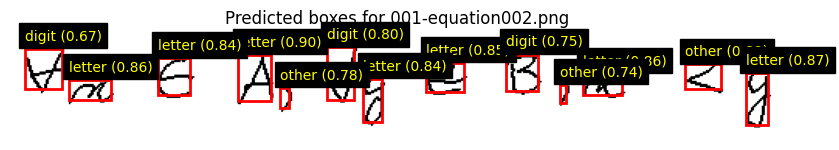

In [ ]:
img_path = root+"/001-equation002.png"

boxes = [
    ("letter", 0.90, [146.7, 14.7, 167.8, 44.6]),
    ("other", 0.89, [435.1, 20.7, 458.4, 36.8]),
    ("letter", 0.87, [474.2, 26.5, 488.5, 59.5]),
    ("letter", 0.86, [37.3, 30.7, 64.7, 43.9]),
    ("letter", 0.86, [368.9, 26.7, 394.4, 40.5]),
    ("letter", 0.85, [268.1, 19.9, 292.5, 38.7]),
    ("letter",  0.84, [94.7, 16.8, 115.9, 40.7]),
    ("letter", 0.84, [227.4, 30.1, 239.6, 57.6]),
    ("digit",  0.80, [203.9, 9.8, 221.7, 44.0]),
    ("other", 0.78, [173.8, 36.1, 179.7, 49.0]),
    ("digit", 0.75, [319.3, 14.5, 340.1, 37.9]),
    ("other", 0.74, [354.1, 34.0, 358.5, 45.4]),
    ("digit",  0.67, [9.0, 10.8, 33.0, 36.7]),
]

# Ensure path exists before opening
p = Path(img_path)
if not p.exists():
    raise FileNotFoundError(f"Image not found at path: {img_path}. Ensure the path is accessible from this notebook environment and that Drive is mounted if needed.")

img = Image.open(p).convert('RGB')

fig, ax = plt.subplots(1, figsize=(10,8))
ax.imshow(img)
for (label, conf, box) in boxes:
    x1,y1,x2,y2 = box
    w = x2 - x1
    h = y2 - y1
    rect = patches.Rectangle((x1,y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Annotate label and confidence above the box
    txt = f"{label} ({conf:.2f})"
    ax.text(x1, max(0,y1-6), txt, fontsize=10, color='yellow', backgroundcolor='black')

ax.axis('off')
plt.title('Predicted boxes for 001-equation002.png')
plt.show()
